## Introduction to SHAP Values and their Application in Machine Learning

### Reza Bagheri

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import xgboost
import shap
from sklearn.datasets import load_boston
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor
from itertools import combinations
import scipy
from more_itertools import distinct_permutations
from sklearn.cluster import KMeans
import math
from sklearn.cluster import KMeans
from numpy.random import choice

%matplotlib inline

### Linear SHAP (for a linear model with feature independence)

In [2]:
# Defining the dataset
X = pd.DataFrame({'a': [2, 4, 8, 0, 3, 6, 9],
             'b': [1, 5, 0, 7, 1, -2, 5]})
y = 5*X['a'] + 2*X['b'] + 3

In [3]:
y

0    15
1    33
2    43
3    17
4    20
5    29
6    58
dtype: int64

In [4]:
# Defining a linear model
linear_model = LinearRegression()
linear_model.fit(X, y)

print("Model coefficients:")
for i in range(X.shape[1]):
    print(X.columns[i], "=", linear_model.coef_[i].round(4))

Model coefficients:
a = 5.0
b = 2.0


In [5]:
X[:1]

,a,b
0,2,1


In [6]:
shap_values = ((X[:1] - X.mean()) * linear_model.coef_)
shap_values_table = shap_values.T
shap_values_table.columns = ['SHAP_value']
shap_values_table

,SHAP_value
a,-12.857143
b,-2.857143


#### Linear SHAP using the SHAP library

In [7]:
explainer = shap.LinearExplainer(linear_model, X)
shap_values = explainer.shap_values(X[:1])
print(shap_values)

[[-12.85714286  -2.85714286]]


### Exact SHAP 

In [8]:
d = load_boston()
df = pd.DataFrame(d['data'], columns=d['feature_names'])
y = pd.Series(d['target'])
X = df[['LSTAT', 'AGE', 'RAD','NOX']]
X100 = X[100:200] 

linear_model2 = LinearRegression()
linear_model2.fit(X, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [9]:
def coalition_worth(model, X_train, x, coalition):
    coalition_features = {c: x[c] for c in coalition} 
    return model.predict(X_train.assign(**coalition_features)).mean()

def coalitions(x, col):
    remaining_features = [feature for feature in x.index if feature != col]
    for feature in range(len(remaining_features) + 1):
        for coalition in combinations(remaining_features, feature):
            yield list(coalition)
            
def coalition_contribution(model, X_train, x, col, coalition):
    marginal_gain = coalition_worth(model, X_train, x, coalition + [col]) - coalition_worth(model, X_train, x, coalition)
    num_coalitions = 1 / (scipy.special.comb(len(x) - 1, len(coalition)) * len(x))
    return num_coalitions * marginal_gain  
            
def calculate_exact_shap_values(model, X_train, X_sample):
    if isinstance(X_sample, pd.Series):
        X_sample = pd.DataFrame(X_sample).T
    shap_values_list = []
    for i in range(X_sample.shape[0]):
        x = X_sample.iloc[i]
        shap_values = []
        for col in X_train.columns:
            shap_value =  np.sum([coalition_contribution(model, X_train, x, col, coalition) for coalition in coalitions(x, col)])
            shap_values.append(shap_value)
        shap_values_list.append(shap_values)
    phi0 = np.average(model.predict(X_train))
    return phi0, shap_values_list

In [10]:
calculate_exact_shap_values(linear_model2, X100, X.iloc[0])

(22.998930866827823,
 [[7.809214247585507,
   -0.7308440229196315,
   0.1290501127229501,
   0.23758951510828266]])

In [11]:
pd.DataFrame({'feature': X100.columns,
              'SHAP_value': calculate_exact_shap_values(linear_model2, X100, X.iloc[0])[1][0]})

,feature,SHAP_value
0,LSTAT,7.809214
1,AGE,-0.730844
2,RAD,0.129050
3,NOX,0.237590


#### Exact SHAP using the SHAP library

In [12]:
explainer = shap.Explainer(linear_model2, X100)
shap_values = explainer.shap_values(X.iloc[0:1])
shap_values

array([[ 7.80921425, -0.73084402,  0.12905011,  0.23758952]])

In [13]:
explainer.expected_value

22.998930866827834

In [14]:
explainer = shap.Explainer(linear_model2, X[:150])
shap_values = explainer.shap_values(X.iloc[0:1])
shap_values

array([[ 8.88370884e+00, -2.97655621e-01,  1.17561972e-01,
        -1.48202335e-03]])

In [15]:
calculate_exact_shap_values(linear_model2, X[:150], X.iloc[0])

(22.521908424669917,
 [[7.993180897252836,
   -0.11946396867250808,
   0.11973195423751992,
   -0.07141658816282939]])

### Kernel SHAP

In [16]:
def comb(n, k):
    return math.factorial(n) / (math.factorial(k) * math.factorial(n - k))

def pi_x(num_features, num_avaialable_features):  
    return (num_features - 1) / (comb(num_features, num_avaialable_features) \
            * num_avaialable_features * (num_features - num_avaialable_features))

def generate_coalition_vectors(num_features):
    coalition_vectors = [[0.0] * num_features]
    for num_avaialable_features in range(1, num_features+1):
        for x in combinations(range(num_features), num_avaialable_features):
            coalition_vectors.append([1.0 if i in x else 0.0 for i in range(num_features)])
    return coalition_vectors

def generate_pi_values(coalition_vectors):
    pi_values = []
    num_features = len(coalition_vectors[0])
    for coalition_vector in coalition_vectors:
        num_avaialable_features = np.count_nonzero(coalition_vector)
        try:
            pi_values.append(pi_x(num_features, num_avaialable_features))
        except:
            pi_values.append(1e7)
    return pi_values 

def f_x_z_prime(predictor, X_train, weights, coalition_vectors, instance):
    N = X_train.shape[0] 
    num_coalition_vectors = len(coalition_vectors)
    filled_X_train = np.tile(X_train, (num_coalition_vectors, 1)) 
    for i in range(0, num_coalition_vectors):
        mask = coalition_vectors[i]        
        filled_X_train[i*N: (i+1)*N, :] = np.where(mask, instance, filled_X_train[i*N: (i+1)*N, :])
    preds = predictor(filled_X_train)
    return np.average(preds.reshape(num_coalition_vectors, N), weights=weights, axis=1)

def calculate_shap_values(predictor, fx_avg, X_train, weights, coalition_vectors, 
                          pi_values, X_explain):
    num_instances = X_explain.shape[0]
    num_features = X_explain.shape[1]
    shap_vals = np.zeros((num_instances, num_features))
    W = np.diag(pi_values)
    X = np.array(coalition_vectors)
    R = np.linalg.inv(X.T @ W @ X) @ (X.T @ W)
    phi0 = fx_avg  
    for i in range(0, num_instances):
        y = f_x_z_prime(predictor, X_train, weights, coalition_vectors, X_explain[i]) - fx_avg
        phi = R @ y  # phi = (X^TWX)^-1X^TWy       
        shap_vals[i,:] = phi 
    return phi0, shap_vals
    
def kernel_shap(model_predictor, X_train, weights, X_explain):
    num_train_samples = X_train.shape[0]
    num_features = X_train.shape[1]
    coalition_vectors = generate_coalition_vectors(num_features)

    if isinstance(X_explain, pd.Series) or isinstance(X_explain, pd.DataFrame):
        X_explain = X_explain.values
    if len(X_explain.shape) == 1:
        X_explain = X_explain.reshape(1,-1)
    if isinstance(X_train, pd.DataFrame):
        X_train = X_train.values
    fx_avg = np.average(model_predictor(X_train), weights=weights) 
    pi_values = generate_pi_values(coalition_vectors)
    shap_vals = calculate_shap_values(model_predictor, fx_avg, X_train, weights,
                                      coalition_vectors, pi_values, X_explain)
    return shap_vals


In [17]:
generate_coalition_vectors(3)

[[0.0, 0.0, 0.0],
 [1.0, 0.0, 0.0],
 [0.0, 1.0, 0.0],
 [0.0, 0.0, 1.0],
 [1.0, 1.0, 0.0],
 [1.0, 0.0, 1.0],
 [0.0, 1.0, 1.0],
 [1.0, 1.0, 1.0]]

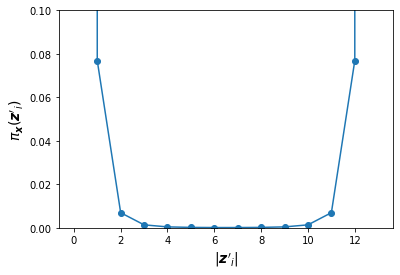

In [18]:
pi_values = [1e7]
for i in range(1, 14):
    try:
        pi_values.append(pi_x(13, i))
    except:
        pi_values.append(1e7)
plt.plot(pi_values, marker='o')
plt.xlabel("$|\mathregular{z}'_i|$", fontsize=14, weight="bold", style="italic",)
plt.ylabel("$\pi_\mathregular{x}(\mathregular{z}'_i)$", fontsize=14, weight="bold", style="italic",)
plt.ylim([0, 0.1])
plt.show()

In [19]:
d = load_boston()
df = pd.DataFrame(d['data'], columns=d['feature_names'])
X = df[['AGE', 'RAD', 'TAX','DIS', 'RM', 'LSTAT', 'B', 'INDUS', 'CHAS']]
y = pd.Series(d['target'])

rf_model = RandomForestRegressor(max_depth=6, random_state=0, n_estimators=10).fit(X, y)

In [20]:
X_train = X.iloc[:100].copy()
data_to_explain = X.iloc[470:471].copy()
weights = np.ones(len(X_train)) / len(X_train)
shap_values = kernel_shap(rf_model.predict, X_train.values, weights, data_to_explain)
shap_values

(22.74244968353333,
 array([[ 4.05579739e-02, -4.91062082e-02, -4.69741706e-01,
          9.28299842e-02, -8.88366342e-01, -2.86693055e+00,
          2.19117329e-01, -3.57934578e-02,  7.10305024e-09]]))

In [21]:
# Kernel SHAP version 2

def comb(n, k):
    return math.factorial(n) / (math.factorial(k) * math.factorial(n - k))

def pi_x(num_features, num_avaialable_features):  
    return (num_features - 1) / (comb(num_features, num_avaialable_features) \
            * num_avaialable_features * (num_features - num_avaialable_features))

def generate_coalition_vectors2(num_features):
    coalition_vectors = []
    for num_avaialable_features in range(1, num_features):
        for x in combinations(range(num_features), num_avaialable_features):
            coalition_vectors.append([1.0 if i in x else 0.0 for i in range(num_features)])
    return coalition_vectors

def generate_pi_values2(coalition_vectors):
    pi_values = []
    num_features = len(coalition_vectors[0])
    for coalition_vector in coalition_vectors:
        num_avaialable_features = np.count_nonzero(coalition_vector)
        pi_values.append(pi_x(num_features, num_avaialable_features))
    return pi_values

def f_x_z_prime(predictor, X_train, weights, coalition_vectors, instance):
    N = X_train.shape[0]
    # number of coalitions = 2^num_features - 2
    num_coalition_vectors = len(coalition_vectors)
    
    # make a matrix by repeating X_train for num_coalition_vectors rows 
    filled_X_train = np.tile(X_train, (num_coalition_vectors, 1)) 
    for i in range(0, num_coalition_vectors):
        mask = coalition_vectors[i]        
        filled_X_train[i*N: (i+1)*N, :] = np.where(mask, instance, filled_X_train[i*N: (i+1)*N, :])
    preds = predictor(filled_X_train)
    return np.average(preds.reshape(num_coalition_vectors, N), weights=weights, axis=1)

def calculate_shap_values2(predictor, fx_avg, fx, X_train, weights, coalition_vectors,
                           pi_values, X_explain):
    num_instances = X_explain.shape[0]
    num_features = X_explain.shape[1]
    shap_vals = np.zeros((num_instances, num_features))
    
    M = X_train.shape[1]
    Wr = np.diag(pi_values)
    Xt = np.array(coalition_vectors)
    Xt_M = Xt[:, -1]  
    Xr = (Xt - np.repeat(np.expand_dims(Xt_M, axis=1), M, axis=1))[:, 0: M-1] 
    Rr = np.linalg.inv(Xr.T @ Wr @ Xr) @ (Xr.T @ Wr)
    phi0 = fx_avg 
    for i in range(0, num_instances):
        y = f_x_z_prime(predictor, X_train, weights, coalition_vectors, X_explain[i]) - fx_avg
        yr = y  - (fx[i] - fx_avg) * Xt_M 
        phi = Rr @ yr                
        phi_n = fx[i] - phi0 - np.sum(phi)
        shap_vals[i,:] = np.append(phi, phi_n)
    return phi0, shap_vals
    
def kernel_shap2(model_predictor, X_train, weights, X_explain):
    num_train_samples = X_train.shape[0]
    num_features = X_train.shape[1]
    coalition_vectors = generate_coalition_vectors2(num_features)

    if isinstance(X_explain, pd.Series) or isinstance(X_explain, pd.DataFrame):
        X_explain = X_explain.values
    if len(X_explain.shape) == 1:
        X_explain = X_explain.reshape(1,-1)
    if isinstance(X_train, pd.DataFrame):
        X_train = X_train.values
    fx = model_predictor(X_explain)
    fx_avg = np.average(model_predictor(X_train), weights=weights)
    pi_values = generate_pi_values2(coalition_vectors)
    shap_vals = calculate_shap_values2(model_predictor, fx_avg, fx, X_train, weights,
                                      coalition_vectors, pi_values, X_explain)
    return shap_vals

In [22]:
shap_values = kernel_shap2(rf_model.predict, X_train, weights, data_to_explain)
shap_values

(22.74244968353333,
 array([[ 4.05579906e-02, -4.91062100e-02, -4.69741717e-01,
          9.28299916e-02, -8.88366357e-01, -2.86693056e+00,
          2.19117328e-01, -3.57934593e-02,  4.44089210e-16]]))

In [23]:
# Kernel SHAP with sampling

def calculate_shap_values3(predictor, fx_avg, fx, X_train, weights, 
                           coalition_vectors, X_explain):
    num_instances = X_explain.shape[0]
    num_features = X_explain.shape[1]
    shap_vals = np.zeros((num_instances, num_features))
    
    M = X_train.shape[1]
    Xt = np.array(coalition_vectors)
    Xt_M = Xt[:, -1]  
    X_D = (Xt - np.repeat(np.expand_dims(Xt_M, axis=1), M, axis=1))[:, 0: M-1] 
    R_D = np.linalg.inv(X_D.T @ X_D) @ X_D.T
    phi0 = fx_avg 
    for i in range(0, num_instances):
        y = f_x_z_prime(predictor, X_train, weights, coalition_vectors, X_explain[i]) - fx_avg
        y_D = y  - (fx[i] - fx_avg) * Xt_M 
        phi = R_D @ y_D               
        phi_n = fx[i] - phi0 - np.sum(phi)
        shap_vals[i,:] = np.append(phi, phi_n)
    return phi0, shap_vals
    
def kernel_shap3(model_predictor, X_train, weights, X_explain):
        num_train_samples = X_train.shape[0]
        num_features = X_train.shape[1]
        coalition_vectors = generate_coalition_vectors2(num_features)
        
        if isinstance(X_explain, pd.Series) or isinstance(X_explain, pd.DataFrame):
            X_explain = X_explain.values
        if len(X_explain.shape) == 1:
            X_explain = X_explain.reshape(1,-1)
        if isinstance(X_train, pd.DataFrame):
            X_train = X_train.values
        fx = model_predictor(X_explain)
        fx_avg = np.average(model_predictor(X_train), weights=weights)
        pi_values = generate_pi_values2(coalition_vectors)
        
        pi_values_normalized = np.array(pi_values)
        pi_values_normalized /= pi_values_normalized.sum()
        
        num_samples = 2**(num_features-1)
        sampled_indices = choice(len(pi_values), num_samples, p=pi_values_normalized)
        sampled_coalition_vectors = [coalition_vectors[i] for i in sampled_indices]
        
        shap_vals = calculate_shap_values3(model_predictor, fx_avg, fx, X_train, weights,
                                          sampled_coalition_vectors, X_explain)
        return shap_vals

In [24]:
X1 = df
weights1 = np.ones(len(X1)) / len(X1)
rf_model1 = RandomForestRegressor(max_depth=6, random_state=0, n_estimators=10).fit(X1, y)

In [25]:
np.random.seed(seed=0)
shap_values = kernel_shap3(rf_model1.predict, X1, weights1, X1.iloc[:1])
shap_values

(22.529999735021796,
 array([[ 3.37054690e-01,  2.02344887e-02,  1.57606624e-01,
         -3.26786033e-02,  6.77205865e-02, -3.67173000e-04,
          2.33844154e-02, -4.46929559e-01, -1.51922123e-01,
         -7.46328445e-02,  2.89184823e-01, -1.15173921e-01,
          4.13584587e+00]]))

#### Kernel SHAP using the SHAP library

In [26]:
explainer = shap.KernelExplainer(rf_model.predict, X_train)
k_shap_values = explainer.shap_values(data_to_explain)
phi0 = explainer.expected_value
k_shap_values

array([[ 0.04055799, -0.04910621, -0.46974172,  0.09282999, -0.88836636,
        -2.86693056,  0.21911733, -0.03579346,  0.        ]])

In [27]:
phi0

22.742449683533327

In [28]:
explainer = shap.KernelExplainer(rf_model.predict, shap.sample(X, 100))
k_shap_values = explainer.shap_values(data_to_explain)
phi0 = explainer.expected_value
k_shap_values

array([[ 9.13711494e-02, -1.82197032e-01, -5.01031547e-01,
         9.18510711e-01, -1.57577832e+00, -2.50751990e+00,
         2.75453826e-01, -3.90271232e-02, -1.40333333e-03]])

In [29]:
explainer = shap.KernelExplainer(rf_model.predict, shap.kmeans(X, 100))
k_shap_values = explainer.shap_values(data_to_explain)
phi0 = explainer.expected_value
k_shap_values

array([[ 0.08351425, -0.08078016, -0.46471142,  1.00687089, -0.93826199,
        -2.43919855,  0.34099958, -0.10016546,  0.        ]])

In [30]:
kmeans = KMeans(n_clusters=100, random_state=10).fit(X)

cluster_size = np.bincount(kmeans.labels_)
weights = cluster_size / np.sum(cluster_size)
X_train_kmeans = kmeans.cluster_centers_
shap_values = kernel_shap2(rf_model.predict, X_train_kmeans, weights, data_to_explain)
shap_values

(21.527635212102094,
 array([[ 0.08022715, -0.0687132 , -0.52343903,  1.01031463, -0.97025395,
         -2.52935691,  0.35800456, -0.09940176,  0.        ]]))

### SHAP values of tree-based models

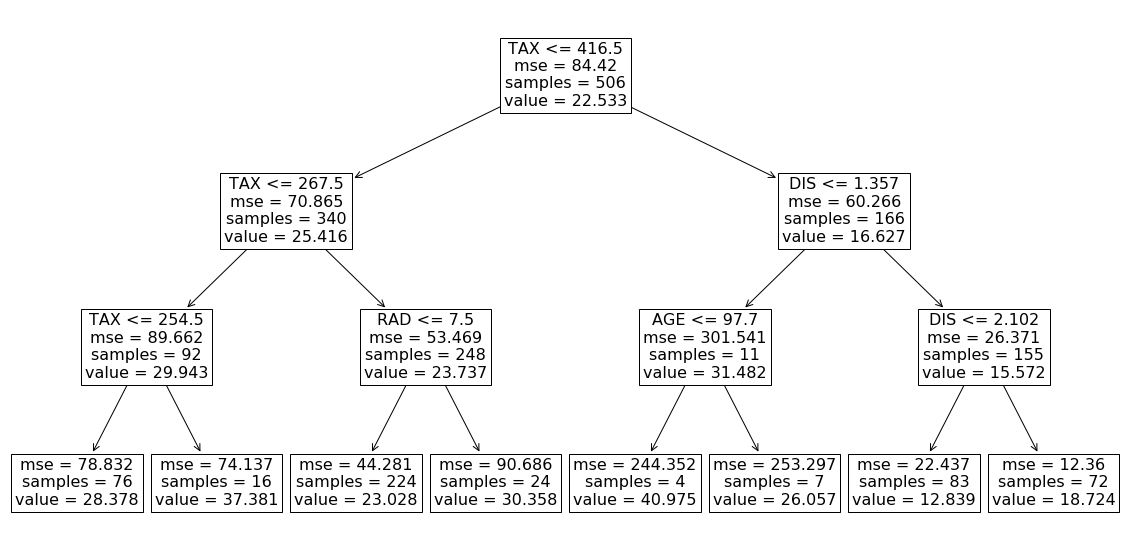

In [31]:
d = load_boston()
df = pd.DataFrame(d['data'], columns=d['feature_names'])
y = pd.Series(d['target'])
X = df[['AGE', 'RAD', 'TAX','DIS']]
 
tree_model = DecisionTreeRegressor(max_depth=3)
tree_model.fit(X, y)

fig = plt.figure(figsize=(20, 10))
plot_tree(tree_model, feature_names=X.columns, fontsize =16)
plt.show()

In [32]:
X.iloc[0]

AGE     65.20
RAD      1.00
TAX    296.00
DIS      4.09
Name: 0, dtype: float64

In [33]:
tree_model.predict(X.iloc[0:1])

array([23.02767857])

In [34]:
def expvalue(clf, x, S):
    def g(node, w):
        left_child = clf.tree_.children_left[node]
        right_child = clf.tree_.children_right[node]
        if left_child == right_child:  # node is a leaf 
            return w*clf.tree_.value[node].squeeze()
        else: # internal node
            feature = x.index[clf.tree_.feature[node]]
            if feature in S:
                if x.loc[feature] <= clf.tree_.threshold[node]:
                    return g(left_child, w) 
                else:
                    return g(right_child, w) 
            else:    
                w_left = clf.tree_.n_node_samples[left_child] / clf.tree_.n_node_samples[node]
                w_right = clf.tree_.n_node_samples[right_child] / clf.tree_.n_node_samples[node]
                return g(left_child, w * w_left) + g(right_child, w * w_right)
    return g(0,1)

In [35]:
#  (224/248) * 23.028 + (24/248)*30.358
expvalue(tree_model, x=X[:1].T.squeeze(), S=['TAX','AGE', 'DIS'])

23.73709677419356

In [36]:
# ((92/506)*29.943+(248/506)*23.028)+(166/506)*((11/166)*((4/11)*40.975 +(7/11)*26.057)+(155/166)*((83/155)*12.839+(72/155)*18.724)) 
expvalue(tree_model, x=X[:1].T.squeeze(), S=['RAD'])

22.185107284020333

In [37]:
expvalue(tree_model, x=X[:1].T.squeeze(), S=[])

22.532806324110677

In [38]:
def coalitions(x, col):
    remaining_features = [feature for feature in x.index if feature != col]
    for feature in range(len(remaining_features) + 1):
        for coalition in combinations(remaining_features, feature):
            yield list(coalition)
            
def coalition_contribution1(model, x, col, coalition):
    marginal_gain = expvalue(model, x, coalition + [col]) - expvalue(model, x, coalition)
    num_coalitions = 1 / (scipy.special.comb(len(x) - 1, len(coalition)) * len(x))
    return num_coalitions * marginal_gain  
            
def calculate_exact_tree_shap_values(model, X_sample):
    if isinstance(X_sample, pd.Series):
        X_sample = pd.DataFrame(X_sample).T
    shap_values_list = []
    for i in range(X_sample.shape[0]):
        x = X_sample.iloc[i]
        shap_values = []
        for col in X_sample.columns:
            shap_value = np.sum([coalition_contribution1(model, x, col, coalition) for coalition in coalitions(x, col)])
            shap_values.append(shap_value)
        shap_values_list.append(shap_values)
    return model.tree_.value[0].squeeze().item(), shap_values_list

In [39]:
calculate_exact_tree_shap_values(tree_model, X.iloc[470])

(22.532806324110698,
 [[0.17363555010556136,
   1.622595520421605,
   -6.753886031609975,
   1.1484597480832435]])

### Tree SHAP

In [40]:
def tree_shap(tree, X_explain):
    if isinstance(X_explain, pd.Series):
        X_explain = X_explain.values
    elif isinstance(X_explain, pd.DataFrame):
        X_explain = X_explain.values
    tree = tree.tree_

    if len(X_explain.shape) == 1:
        phi = np.zeros(X_explain.shape[0])
        calculate_tree_shap(tree, X_explain, phi)
    elif len(X_explain.shape) == 2:
        phi = np.zeros((X_explain.shape[0], X_explain.shape[1]))
        for i in range(X_explain.shape[0]):
            calculate_tree_shap(tree, X_explain[i,:], phi[i,:])
    return tree.value.squeeze()[0].item(), phi

In [41]:
def extend(m, pz, po, pi): 
    l = len(m)
    m = m.copy()
    m.loc[l] = [pi, pz, po, 1 if l==0 else 0]  

    for i in range(l - 1, -1, -1):
        m.iloc[i+1]['w'] += po * m.iloc[i]['w'] * (i + 1) / (l + 1)
        m.iloc[i]['w'] = pz * m.iloc[i]['w'] * (l - i) / (l + 1)
    return m


def unwind(m, i): 
    m = m.copy()
    l = len(m) - 1
    n = m.iloc[l]['w'] 
    for j in range(l - 1, -1, -1):
        if m.iloc[i]['o'] != 0:
            temp = m.iloc[j]['w']
            m.iloc[j]['w'] = n * (l + 1) / ((j + 1) * m.iloc[i]['o'])
            n = temp - m.loc[j]['w'] * m.loc[i]['z'] * (l - j) / (l + 1)
        else:
            m.iloc[j]['w'] = (m.iloc[j]['w'] * (l + 1)) / (m.iloc[i]['z'] * (l - j))

    for j in range(i, l):
        m.iloc[j]['d'] = m.loc[j+1]['d']
        m.iloc[j]['z'] = m.loc[j+1]['z']
        m.iloc[j]['o'] = m.loc[j+1]['o']
    return m.iloc[:l] 

def calculate_tree_shap(tree, x, phi):
    def tree_shap_recursive(j, m, pz, po, pi):   
        # extend the unique path
        m = extend(m, pz, po, pi)
        dj = features[j]

        # leaf node
        if children_right[j] == -1:
            for i in range(1, len(m)):
                w = unwind(m, i).w.sum()
                phi[int(m.iloc[i]["d"])] += w * (m.iloc[i]["o"] - m.iloc[i]["z"]) * values[j] 

        # internal node
        else:
            h = 0
            cleft = children_left[j]
            cright = children_right[j]

            h = cleft if x[dj] < thresholds[j] else cright
            c = cright if h == cleft else cleft
            rj = node_sample_weight[j]
            rh = node_sample_weight[h] 
            rc = node_sample_weight[c] 
            iz = 1
            io = 1

            k = 0
            while (k < len(m)):
                if m.loc[k]['d'] == dj:
                    break
                k += 1

            if k != len(m):          
                iz = m.iloc[k]['z']
                io = m.iloc[k]['o']         
                m = unwind(m, k)           

            tree_shap_recursive(h, m, rh/rj*iz, io, dj)
            tree_shap_recursive(c, m, rc/rj*iz, 0, dj)
    
    children_left = tree.children_left 
    children_right = tree.children_right 
    features = tree.feature  
    thresholds =tree.threshold 
    values = tree.value.squeeze() 
    node_sample_weight = tree.weighted_n_node_samples
    
    m = pd.DataFrame({}, columns=['d', 'z', 'o', 'w'])
    tree_shap_recursive(0, m, 1, 1, -1)


In [42]:
tree_shap(tree_model, X.iloc[470])

(22.532806324110698,
 array([ 0.17363555,  1.62259552, -6.75388603,  1.14845975]))

#### Tree SHAP using the SHAP library

In [43]:
explainer = shap.TreeExplainer(tree_model)
shap_values = explainer.shap_values(X.iloc[470])
shap_values

array([ 0.17363555,  1.62259552, -6.75388603,  1.14845975])

In [44]:
explainer.expected_value

array([22.53280632])

### Tree SHAP for tree ensembles

In [45]:
def tree_shap_ensemble(tree_ensemble, X_explain):
    # convert dataframes
    if isinstance(X_explain, pd.Series):
        X_explain = X_explain.values
    elif isinstance(X_explain, pd.DataFrame):
        X_explain = X_explain.values
    trees = [tree.tree_ for tree in tree_ensemble.estimators_]

    if len(X_explain.shape) == 1:
        phi = np.zeros(X_explain.shape[0])
        for tree in trees:    
            calculate_tree_shap(tree, X_explain, phi)
        phi /= len(trees)

    elif len(X_explain.shape) == 2:
        phi = np.zeros((X_explain.shape[0], X_explain.shape[1]))
        for i in range(X_explain.shape[0]):
            for tree in trees:
                calculate_tree_shap(tree, X_explain[i,:], phi[i,:])
        phi /= len(trees)
    phi0 = sum([tree.value.squeeze()[0].item() for tree in trees]) / len(trees)
    return phi0, phi

In [46]:
d = load_boston()
df = pd.DataFrame(d['data'], columns=d['feature_names'])
y = pd.Series(d['target'])
X = df[['AGE', 'RAD', 'TAX','DIS']]
 
rf_model2 = RandomForestRegressor(random_state=0, n_estimators=4).fit(X, y)

In [47]:
tree_shap_ensemble(rf_model2, X.iloc[470])

(22.340563241106732,
 array([-0.60018849,  1.36914776, -6.2207912 ,  2.33626868]))

#### Tree SHAP for tree ensembles using SHAP library

In [48]:
explainer = shap.TreeExplainer(rf_model2)
shap_values = explainer.shap_values(X.iloc[470])
shap_values 

array([-0.60018849,  1.36914776, -6.2207912 ,  2.33626868])

In [49]:
explainer.expected_value

array([22.34056324])

### SHAP Plots

In [50]:
d = load_boston()
df = pd.DataFrame(d['data'], columns=d['feature_names'])
X = df
y = pd.Series(d['target'])

xgb_model = xgboost.XGBRegressor(random_state=1).fit(X, y)

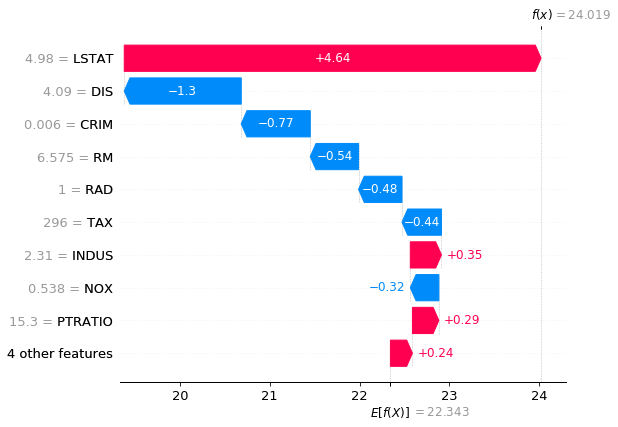

In [51]:
explainer = shap.Explainer(xgb_model, X)
explanation_object = explainer(X)
shap_values = explainer.shap_values(X)

# visualize the first prediction's explanation
shap.plots.waterfall(explanation_object[0])

In [52]:
shap.initjs()
shap.plots.force(explanation_object[0])

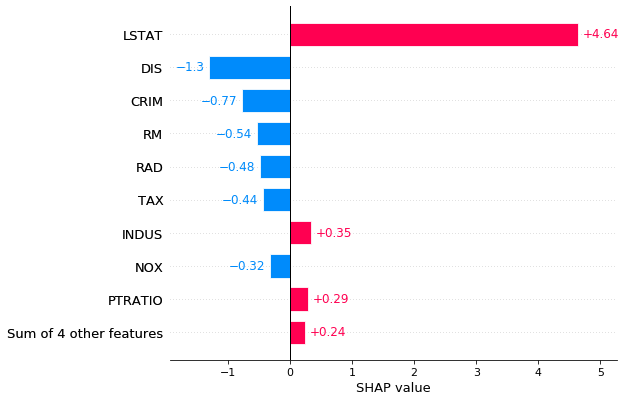

In [53]:
shap.plots.bar(explanation_object[0])

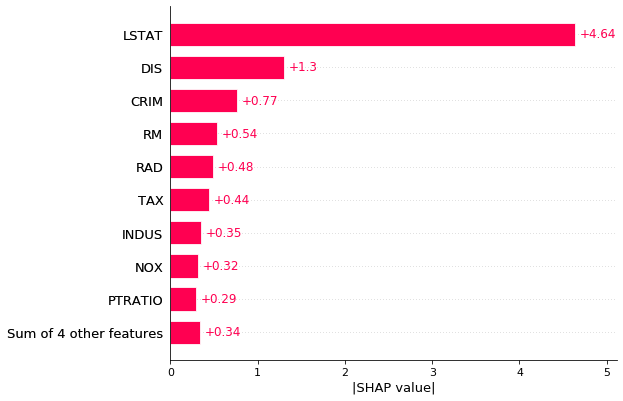

In [54]:
shap.plots.bar(explanation_object[0].abs)

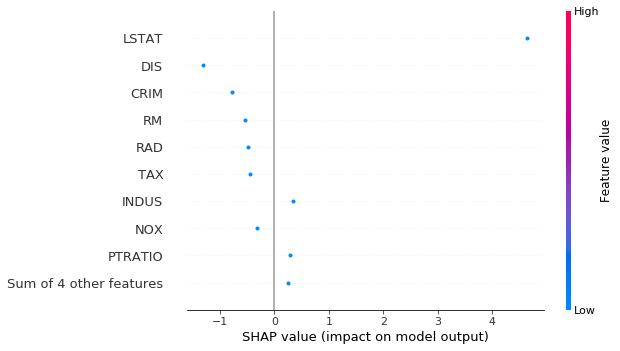

In [55]:
import copy    
shap.plots.beeswarm(copy.deepcopy(explanation_object[0:1]))

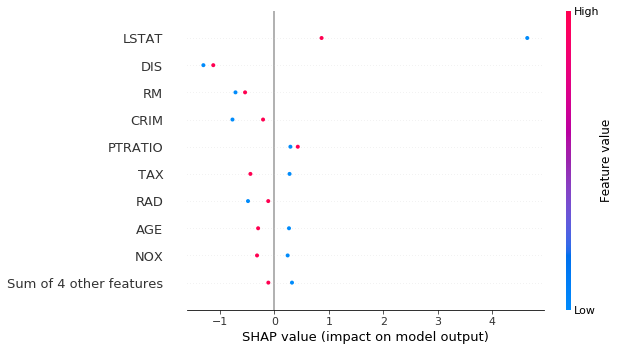

In [56]:
shap.plots.beeswarm(copy.deepcopy(explanation_object[0:2]))

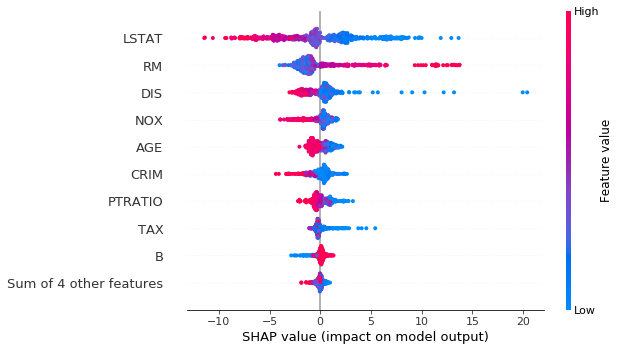

In [57]:
shap.plots.beeswarm(copy.deepcopy(explanation_object))

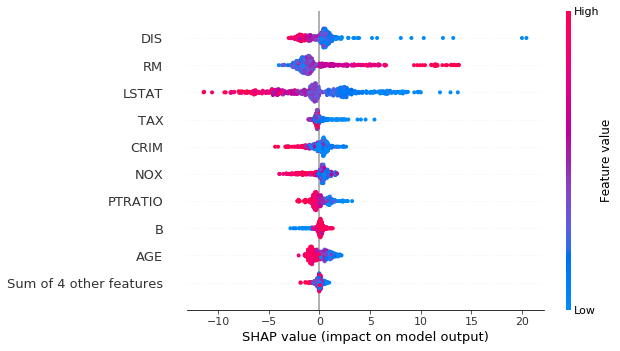

In [58]:
shap.plots.beeswarm(copy.deepcopy(explanation_object), order=explanation_object.abs.max(0))

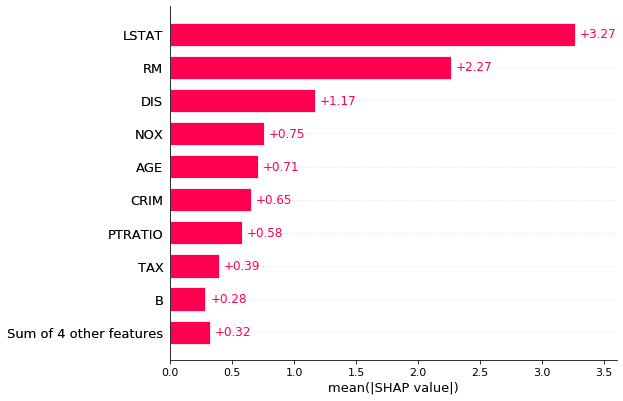

In [59]:
shap.plots.bar(explanation_object)

In [60]:
shap.force_plot(explainer.expected_value, shap_values[0:3,:], X.iloc[0:3,:], plot_cmap="DrDb")

In [61]:
shap.force_plot(explainer.expected_value, shap_values, X, plot_cmap="DrDb")